In [43]:
import pandas as pd
import numpy as np

# Import Regular Expression
import re

# Loading the data
df = pd.read_csv("Data/jumia_phones.csv")

# Display the first few rows of the data to get a sense of the data structure
df.head()

,Name,Price,Old Price,Discount,Rating,Number of Reviews,Search Ranking
0,"XIAOMI Redmi A3, 6.71"", 3GB RAM + 64GB (Dual S...","KSh 11,000",NaN,NaN,4.1 out of 5,4.1 out of 5(220),"Page 1, Rank 1"
1,"Tecno Spark 20, Android 13, 6.6"", 128GB + 4GB ...","KSh 12,925","KSh 15,000",14%,4.4 out of 5,4.4 out of 5(135),"Page 1, Rank 2"
2,"Itel S23 6.6"", 128GB + 4GB RAM, 50MP Camera, (...","KSh 10,000",NaN,NaN,4.2 out of 5,4.2 out of 5(151),"Page 1, Rank 3"
3,"Samsung Galaxy A05, 6.7'' 4GB RAM + 128GB ROM ...","KSh 14,000",NaN,NaN,4.5 out of 5,4.5 out of 5(29),"Page 1, Rank 4"
4,"Itel S23 6.6"", 128GB + 4GB RAM, 50MP Camera, (...","KSh 10,000",NaN,NaN,4.3 out of 5,4.3 out of 5(249),"Page 1, Rank 5"


***

## Data Cleaning

Let us define a function to extract the different phone features from the name column

In [44]:
# Column name to work with
product_column = 'Name'

# Function to extract a feature based on regex and rename the column
def extract_feature(df, column, pattern, feature_name):
    def extractor(name):
        match = re.search(pattern, name)
        return match.group(1).strip() if match else None

    return df[column].apply(extractor).rename(feature_name)

# Define regex patterns
patterns = {
    'Brand': r"(?P<brand>[\w\s]+)(?=\+|,\s|\s|$)",
    'Screen Size': r"(?P<screen_size>\d+(\.\d+)?)(?=['\"]{1,2})",
    'RAM': r"\b(?P<RAM>\d\s?GB)\b",
    'ROM': r"\b(?P<ROM>\d{2,}\s?GB)\b",
    'Color': r"[,-]\s*(?P<Color>([A-Z][a-z]+(?:\s[A-Z][a-z]+)*))\s*(?:\+.*)?(?=\s*\(|$)",
    'Warranty': r"(\d+)\s*(?:YR|WRTY)",
    'Camera': r'(\d+MP)',
    'Battery': r'(\d{4}mAh)',
    'Number of SIMs': r'\(?(Dual\s+Sim|DUAL\s+SIM|Single\s+Sim|Single)\)?'
}

# Extract features using the defined patterns
extracted_features = {
    name: extract_feature(df, product_column, pattern, name)
    for name, pattern in patterns.items()
}

# Special handling for Warranty and Number of SIMs
extracted_features['Warranty'] = extracted_features['Warranty'].apply(lambda x: 2 if x == '2' else (1 if x == '1' else 0))
extracted_features['sim_cards'] = extracted_features['Number of SIMs'].apply(lambda x: 2 if x and 'Dual' in x else 1)

# Clean up the Brand column to title case
extracted_features['Brand'] = extracted_features['Brand'].str.lower().str.title()

# Combine all extracted features into a single DataFrame
extracted_features_df = pd.DataFrame(extracted_features)

# Concatenate with the original DataFrame, excluding the product column
final_df = pd.concat([extracted_features_df, df.drop(columns=[product_column])], axis=1)

# Display the final DataFrame
final_df.head()

,Brand,Screen Size,RAM,ROM,Color,Warranty,Camera,Battery,Number of SIMs,sim_cards,Price,Old Price,Discount,Rating,Number of Reviews,Search Ranking
0,Xiaomi Redmi A3,6.71,3GB,64GB,Midnight Black,2,None,5000mAh,None,1,"KSh 11,000",NaN,NaN,4.1 out of 5,4.1 out of 5(220),"Page 1, Rank 1"
1,Tecno Spark 20,6.6,4GB,128GB,Gravity Black,1,50MP,5000mAh,None,1,"KSh 12,925","KSh 15,000",14%,4.4 out of 5,4.4 out of 5(135),"Page 1, Rank 2"
2,Itel S23,6.6,4GB,128GB,Mystery White,1,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,4.2 out of 5,4.2 out of 5(151),"Page 1, Rank 3"
3,Samsung Galaxy A05,6.7,4GB,128GB,Black,0,50MP,5000mAh,Dual Sim,2,"KSh 14,000",NaN,NaN,4.5 out of 5,4.5 out of 5(29),"Page 1, Rank 4"
4,Itel S23,6.6,4GB,128GB,Starry Black,0,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,4.3 out of 5,4.3 out of 5(249),"Page 1, Rank 5"


In [45]:
# Let us clean the Rating column to keep only the result and rename it to Ratings_out_of_5
final_df['Ratings'] = final_df['Rating'].str.extract(r'(\d+\.\d+)')[0]

# Drop the Rating column
final_df.drop(columns=['Rating'], inplace=True)

# Clean the Number of Reviews column to extract the number in parentheses
final_df['Reviews'] = final_df['Number of Reviews'].str.extract(r'\((\d+)\)')[0]

# Drop the Number of reviews column from the Dataset
final_df.drop(columns=['Number of Reviews'], inplace=True)

# Define regex pattern to extract page and rank
pattern = r'Page (?P<Page>\d+), Rank (?P<Rank>\d+)'

# Extract page and rank into new columns
final_df[['Page', 'Rank']] = final_df['Search Ranking'].str.extract(pattern)

# Display the cleaned DataFrame
final_df.head()

,Brand,Screen Size,RAM,ROM,Color,Warranty,Camera,Battery,Number of SIMs,sim_cards,Price,Old Price,Discount,Search Ranking,Ratings,Reviews,Page,Rank
0,Xiaomi Redmi A3,6.71,3GB,64GB,Midnight Black,2,None,5000mAh,None,1,"KSh 11,000",NaN,NaN,"Page 1, Rank 1",4.1,220,1,1
1,Tecno Spark 20,6.6,4GB,128GB,Gravity Black,1,50MP,5000mAh,None,1,"KSh 12,925","KSh 15,000",14%,"Page 1, Rank 2",4.4,135,1,2
2,Itel S23,6.6,4GB,128GB,Mystery White,1,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,"Page 1, Rank 3",4.2,151,1,3
3,Samsung Galaxy A05,6.7,4GB,128GB,Black,0,50MP,5000mAh,Dual Sim,2,"KSh 14,000",NaN,NaN,"Page 1, Rank 4",4.5,29,1,4
4,Itel S23,6.6,4GB,128GB,Starry Black,0,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,"Page 1, Rank 5",4.3,249,1,5


Let us see which phones are with missing values in the camera column and try to get the camera specs from the internet and impute it in the dataset.

In [46]:
# Filter rows where Camera is NaN
phones_with_nan_camera = final_df[final_df['Camera'].isna()]

# Count the number of unique brands with NaN Camera
phones_with_nan_camera['Brand'].value_counts()

Brand
Xiaomi Redmi 14C       900
Xiaomi Redmi A3        600
Infinix Smart 8        600
Samsung Galaxy A05S    300
Oppo A83 4Gb Ram       300
Oppo A17K              300
Itel A18               300
Name: count, dtype: int64

Let us check the internet and see what the camera specs for these devices are since the list is small. We will ipute these details in the missing values for camera and keep the entries rather than dropping them.

In [47]:
# Dictionary with phone models and their corresponding rear camera megapixels (numeric only) aquired from the internet
camera_specs = {
    "Xiaomi Redmi 14C": 50,  # 50 MP camera
    "Xiaomi Redmi A3": 13,   # 13 MP camera
    "Infinix Smart 8": 13,   # 13 MP camera
    "Samsung Galaxy A05S": 50,  # 50 MP camera
    "Oppo A83 4Gb Ram": 13,   # 13 MP camera
    "Oppo A17K": 50,          # 50 MP camera
    "Itel A18": 5            # 5 MP camera
}

# Function to replace NaN values with the camera specs from the dictionary (numeric only)
def replace_camera_specs(row):
    if pd.isna(row['Camera']) and row['Brand'] in camera_specs:
        return camera_specs[row['Brand']]
    return row['Camera']

# Apply the function to the 'Camera' column
final_df['Camera'] = final_df.apply(replace_camera_specs, axis=1)

# Print the updated DataFrame
final_df.head()

,Brand,Screen Size,RAM,ROM,Color,Warranty,Camera,Battery,Number of SIMs,sim_cards,Price,Old Price,Discount,Search Ranking,Ratings,Reviews,Page,Rank
0,Xiaomi Redmi A3,6.71,3GB,64GB,Midnight Black,2,13,5000mAh,None,1,"KSh 11,000",NaN,NaN,"Page 1, Rank 1",4.1,220,1,1
1,Tecno Spark 20,6.6,4GB,128GB,Gravity Black,1,50MP,5000mAh,None,1,"KSh 12,925","KSh 15,000",14%,"Page 1, Rank 2",4.4,135,1,2
2,Itel S23,6.6,4GB,128GB,Mystery White,1,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,"Page 1, Rank 3",4.2,151,1,3
3,Samsung Galaxy A05,6.7,4GB,128GB,Black,0,50MP,5000mAh,Dual Sim,2,"KSh 14,000",NaN,NaN,"Page 1, Rank 4",4.5,29,1,4
4,Itel S23,6.6,4GB,128GB,Starry Black,0,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,"Page 1, Rank 5",4.3,249,1,5


In [48]:
# Rename Brand to phone_name, Screen Size to display, ROM to storage
final_df.rename(columns={'Brand': 'phone_name', 'Screen Size': 'display', 'ROM': 'storage'}, inplace=True)

# Drop the Search Ranking and Old Price column
final_df.drop(columns=['Search Ranking', 'Old Price', 'Number of SIMs'], inplace=True)

# Change all column names to lowercase and add _ between the parts of the column names
final_df.columns = final_df.columns.str.lower().str.replace(' ', '_')

# Display the cleaned DataFrame
final_df['color'].head(100)

# Get the 97th entry in the final_df
final_df.iloc[97]

phone_name     Itel S23
display             6.6
ram                 8GB
storage           128GB
color              None
warranty              0
camera             50MP
battery         5000mAh
sim_cards             1
price         KSh 9,999
discount            50%
ratings             4.5
reviews              41
page                  3
rank                 18
Name: 97, dtype: object

In [49]:
# Let us check our modified DataFrame
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   phone_name  12000 non-null  object
 1   display     11100 non-null  object
 2   ram         12000 non-null  object
 3   storage     12000 non-null  object
 4   color       9600 non-null   object
 5   warranty    12000 non-null  int64 
 6   camera      12000 non-null  object
 7   battery     9300 non-null   object
 8   sim_cards   12000 non-null  int64 
 9   price       12000 non-null  object
 10  discount    8101 non-null   object
 11  ratings     10200 non-null  object
 12  reviews     11700 non-null  object
 13  page        12000 non-null  object
 14  rank        12000 non-null  object
dtypes: int64(2), object(13)
memory usage: 1.4+ MB


In [50]:
# Check for missing values in the dataframe
final_df.isnull().sum()

phone_name       0
display        900
ram              0
storage          0
color         2400
warranty         0
camera           0
battery       2700
sim_cards        0
price            0
discount      3899
ratings       1800
reviews        300
page             0
rank             0
dtype: int64

In [51]:
# Convert Screen Size to float
final_df['display'] = final_df['display'].astype(float)
final_df['ratings'] = final_df['ratings'].astype(float)

# Convert RAM and ROM to integer
final_df['ram'] = final_df['ram'].str.replace('GB', '').astype(int)
final_df['storage'] = final_df['storage'].str.replace('GB', '').astype(int)

# Convert Page and Rank to integer
final_df['page'] = final_df['page'].astype(int)
final_df['rank'] = final_df['rank'].astype(int)

# Convert Price and Old Price to float
final_df['price'] = final_df['price'].str.replace(r'[^\d]', '', regex=True).astype(float)

# Convert the Reviews to numbers
final_df['reviews'] = final_df['reviews'].fillna(0).astype(float).astype(int)

#View the first 6 rows of the final set
final_df.head()

,phone_name,display,ram,storage,color,warranty,camera,battery,sim_cards,price,discount,ratings,reviews,page,rank
0,Xiaomi Redmi A3,6.71,3,64,Midnight Black,2,13,5000mAh,1,11000.0,NaN,4.1,220,1,1
1,Tecno Spark 20,6.60,4,128,Gravity Black,1,50MP,5000mAh,1,12925.0,14%,4.4,135,1,2
2,Itel S23,6.60,4,128,Mystery White,1,50MP,5000mAh,1,10000.0,NaN,4.2,151,1,3
3,Samsung Galaxy A05,6.70,4,128,Black,0,50MP,5000mAh,2,14000.0,NaN,4.5,29,1,4
4,Itel S23,6.60,4,128,Starry Black,0,50MP,5000mAh,1,10000.0,NaN,4.3,249,1,5


In [52]:
# Drop the color column
final_df.drop(columns=['color'], inplace=True)

# Fill NaN values in the discount column with 0
final_df['discount'] = final_df['discount'].fillna(0)

# Remove letters from battery entries and handle None values
final_df['battery'] = final_df['battery'].apply(lambda x: ''.join(filter(str.isdigit, x)) if isinstance(x, str) else x)

# Remove the % symbol from the discount entries
final_df['discount'] = final_df['discount'].str.replace('%', '')

final_df.head()

,phone_name,display,ram,storage,warranty,camera,battery,sim_cards,price,discount,ratings,reviews,page,rank
0,Xiaomi Redmi A3,6.71,3,64,2,13,5000,1,11000.0,NaN,4.1,220,1,1
1,Tecno Spark 20,6.60,4,128,1,50MP,5000,1,12925.0,14,4.4,135,1,2
2,Itel S23,6.60,4,128,1,50MP,5000,1,10000.0,NaN,4.2,151,1,3
3,Samsung Galaxy A05,6.70,4,128,0,50MP,5000,2,14000.0,NaN,4.5,29,1,4
4,Itel S23,6.60,4,128,0,50MP,5000,1,10000.0,NaN,4.3,249,1,5


In [53]:
# Fill NaN values in the discount column with 0
final_df['discount'] = final_df['discount'].fillna(0)

# Remove letters from camera entries
final_df['camera'] = final_df['camera'].apply(lambda x: ''.join(filter(str.isdigit, x)) if isinstance(x, str) else x)

# View the first 10 rows of the final DataFrame to check for any changes in the data structure and values
final_df.head(10)

,phone_name,display,ram,storage,warranty,camera,battery,sim_cards,price,discount,ratings,reviews,page,rank
0,Xiaomi Redmi A3,6.71,3,64,2,13,5000,1,11000.0,0,4.1,220,1,1
1,Tecno Spark 20,6.60,4,128,1,50,5000,1,12925.0,14,4.4,135,1,2
2,Itel S23,6.60,4,128,1,50,5000,1,10000.0,0,4.2,151,1,3
3,Samsung Galaxy A05,6.70,4,128,0,50,5000,2,14000.0,0,4.5,29,1,4
4,Itel S23,6.60,4,128,0,50,5000,1,10000.0,0,4.3,249,1,5
5,Samsung Galaxy A15,6.50,4,128,0,50,5000,1,17445.0,42,4.2,420,1,6
6,Samsung Galaxy A05,6.70,4,128,0,50,5000,2,13899.0,40,3.9,116,1,7
7,Xiaomi Redmi 13C,6.74,8,256,0,50,5000,2,16899.0,44,NaN,151,1,8
8,Tecno Spark 20,6.60,8,128,0,50,None,2,14399.0,45,4.1,198,1,9
9,Itel S23,6.60,4,128,0,50,5000,1,10000.0,0,4.2,111,1,10


In [54]:
# Get the mode (most frequent value) from the 'battery' column
battery_mode = final_df['battery'].mode()[0]

# Fill missing values in 'Battery' column with the mode value
final_df['battery'] = final_df['battery'].fillna(battery_mode)

# Check the DataFrame info to see if the missing values were filled
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   phone_name  12000 non-null  object 
 1   display     11100 non-null  float64
 2   ram         12000 non-null  int64  
 3   storage     12000 non-null  int64  
 4   warranty    12000 non-null  int64  
 5   camera      12000 non-null  object 
 6   battery     12000 non-null  object 
 7   sim_cards   12000 non-null  int64  
 8   price       12000 non-null  float64
 9   discount    12000 non-null  object 
 10  ratings     10200 non-null  float64
 11  reviews     12000 non-null  int64  
 12  page        12000 non-null  int64  
 13  rank        12000 non-null  int64  
dtypes: float64(3), int64(7), object(4)
memory usage: 1.3+ MB


In [55]:
# Let us drop the None values from the dataframe
final_df = final_df.dropna()

# Display the final DataFrame
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9600 entries, 0 to 11998
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   phone_name  9600 non-null   object 
 1   display     9600 non-null   float64
 2   ram         9600 non-null   int64  
 3   storage     9600 non-null   int64  
 4   warranty    9600 non-null   int64  
 5   camera      9600 non-null   object 
 6   battery     9600 non-null   object 
 7   sim_cards   9600 non-null   int64  
 8   price       9600 non-null   float64
 9   discount    9600 non-null   object 
 10  ratings     9600 non-null   float64
 11  reviews     9600 non-null   int64  
 12  page        9600 non-null   int64  
 13  rank        9600 non-null   int64  
dtypes: float64(3), int64(7), object(4)
memory usage: 1.1+ MB


In [56]:
# let us convert the battery, camera, and discount entries to integer
final_df['battery'] = final_df['battery'].astype(int)
final_df['camera'] = final_df['camera'].astype(int)
final_df['discount'] = final_df['discount'].astype(int)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9600 entries, 0 to 11998
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   phone_name  9600 non-null   object 
 1   display     9600 non-null   float64
 2   ram         9600 non-null   int64  
 3   storage     9600 non-null   int64  
 4   warranty    9600 non-null   int64  
 5   camera      9600 non-null   int64  
 6   battery     9600 non-null   int64  
 7   sim_cards   9600 non-null   int64  
 8   price       9600 non-null   float64
 9   discount    9600 non-null   int64  
 10  ratings     9600 non-null   float64
 11  reviews     9600 non-null   int64  
 12  page        9600 non-null   int64  
 13  rank        9600 non-null   int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 1.1+ MB


***

## Exploratory Data Analysis (EDA) for the price feature
Performing a comprehensive EDA on the price feature will help us understand its distribution, relationships with other variables, and potential outliers. Here is step by step process we will follow for a thorough EDA of the price feature using pandas, matplotlib, and seaborn.

1. **Importing Libraries:**
First, we need to import the necessary libraries.

2. **Basic Information and Descriptive Statistics:**
We will start by understanding the basic statistics and characteristics of the price feature.

3. **Distribution of price:**
Next, we will plot the distribution of the price feature using both a histogram and a kernel density estimate (KDE) plot to understand its spread and shape.

4. **Boxplot to Detect Outliers:**
A boxplot is a good way to visually identify potential outliers in the price feature.

5. **Price Correlation with Other Features:**
To understand how price relates to other numerical features, we can compute the correlation matrix and visualize it with a heatmap.
This will show us the correlation values between price and other numerical features. Positive correlations suggest that as one feature increases, so does the price, and vice versa.

6. **Price vs Other Features (Scatter Plots):**
You may want to visualize how price relates to each of the top correlated features (e.g., storage, camera, battery, etc.).

7. **Price vs Categorical Features:**
You may also want to investigate how categorical features (e.g., brand, warranty, sim_cards) relate to the price. This can be done using boxplots or violin plots.

8. **Outliers Detection:**
If you want to perform a more statistical approach to detect outliers in the price feature, you can use the Z-score or IQR (Interquartile Range) method.
**Z-score Method:** Identifying outliers where the absolute Z-score is greater than 3.
**IQR Method:** Identifying outliers using the IQR range.

9. **Skewness and Kurtosis:**
Finally, you may want to assess the distribution of the price using skewness and kurtosis to understand if it's normally distributed.
**Skewness:** If skewness is positive, the distribution is right-skewed (long tail on the right); if negative, the distribution is left-skewed.
**Kurtosis:** Positive kurtosis indicates a distribution with heavy tails or outliers, while negative kurtosis indicates a light-tailed distribution.

After this EDA, we will have a better understanding of the price feature and its relationship with other features. Depending on our findings, we may choose to handle outliers, transform the data (e.g., log-transformation for skewed data), or further explore relationships with categorical variables.

In [57]:
# Importing the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Display basic information about the data
print("Basic Info about the Dataset")
print(final_df.info())

# Display summary statistics for 'price' feature
print("\nDescriptive Statistics for 'price' feature")
print(final_df['price'].describe())

Basic Info about the Dataset
<class 'pandas.core.frame.DataFrame'>
Index: 9600 entries, 0 to 11998
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   phone_name  9600 non-null   object 
 1   display     9600 non-null   float64
 2   ram         9600 non-null   int64  
 3   storage     9600 non-null   int64  
 4   warranty    9600 non-null   int64  
 5   camera      9600 non-null   int64  
 6   battery     9600 non-null   int64  
 7   sim_cards   9600 non-null   int64  
 8   price       9600 non-null   float64
 9   discount    9600 non-null   int64  
 10  ratings     9600 non-null   float64
 11  reviews     9600 non-null   int64  
 12  page        9600 non-null   int64  
 13  rank        9600 non-null   int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 1.1+ MB
None

Descriptive Statistics for 'price' feature
count     9600.000000
mean     14123.635313
std       4306.461803
min       7000.000000
25%      108

***Dataset Overview***
The dataset consists of 9,600 mobile phone entries with 14 features, including details like display size, RAM, storage, warranty, camera, battery, and price. The data is represented in a Pandas DataFrame, and all columns contain non-null values.
The price values range from 7,000 to 24,999, with most phones priced between 10,863 and 15,437.

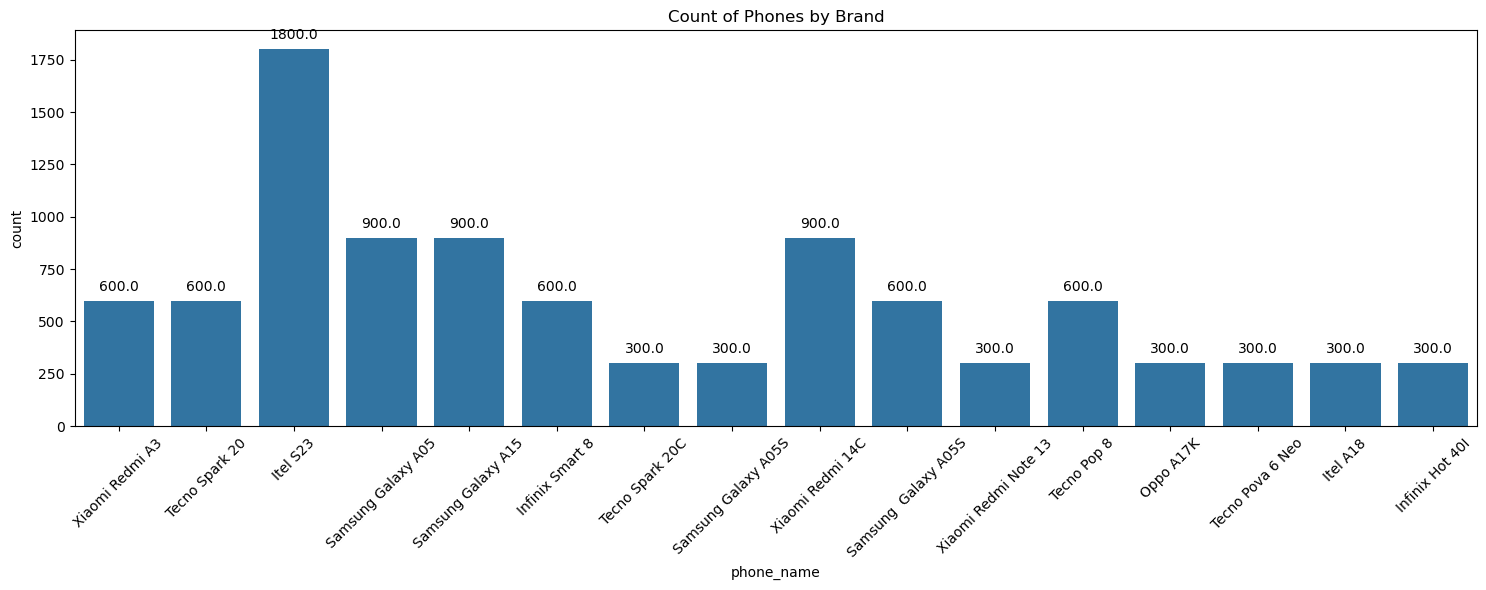

In [58]:
# Plotting a count plot of phone brands in final_df with annotations and rotated labels for better readability
# Set figure size for the plot
plt.figure(figsize=(15, 6))
# Count plot for 'Brand' column in the dataset
ax1 = sns.countplot(x='phone_name', data=final_df)
plt.title('Count of Phones by Brand')
# Annotate each bar with its corresponding count value
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
# Automatically adjust layout to prevent clipping
plt.tight_layout()
plt.show()

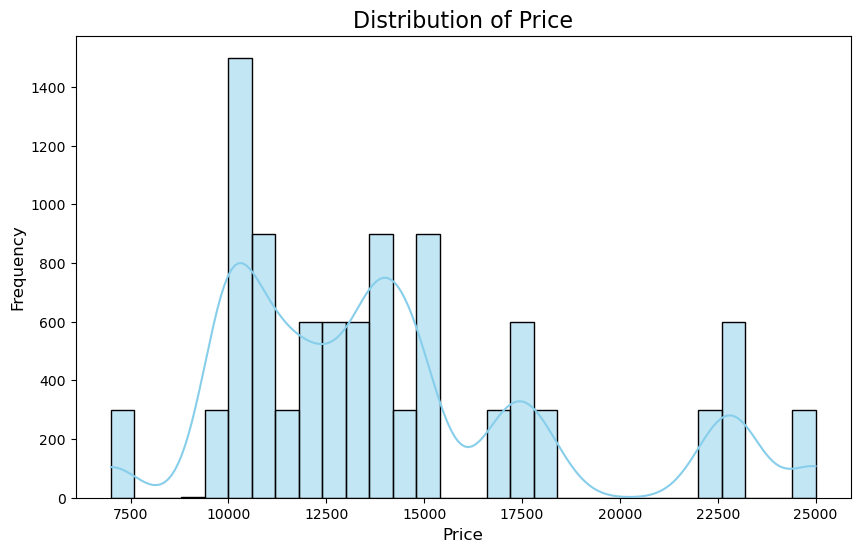

In [59]:
# Plot the distribution of 'price'
plt.figure(figsize=(10, 6))

# Histogram with KDE overlay
sns.histplot(final_df['price'], kde=True, bins=30, color='skyblue')

plt.title('Distribution of Price', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

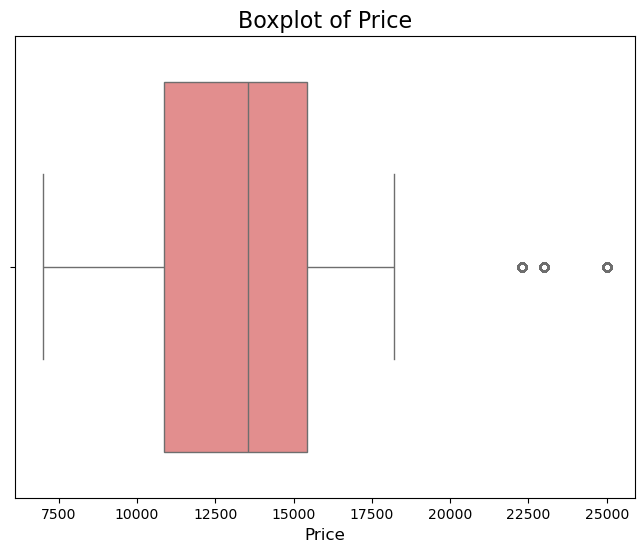

In [60]:
# Boxplot to detect outliers
plt.figure(figsize=(8, 6))

sns.boxplot(x=final_df['price'], color='lightcoral')

plt.title('Boxplot of Price', fontsize=16)
plt.xlabel('Price', fontsize=12)

plt.show()

Ok so let us plot a correlation matrix to see how the different features are related to each other. But first let us one hot encode the phone name column inorder to change it to numerical value.


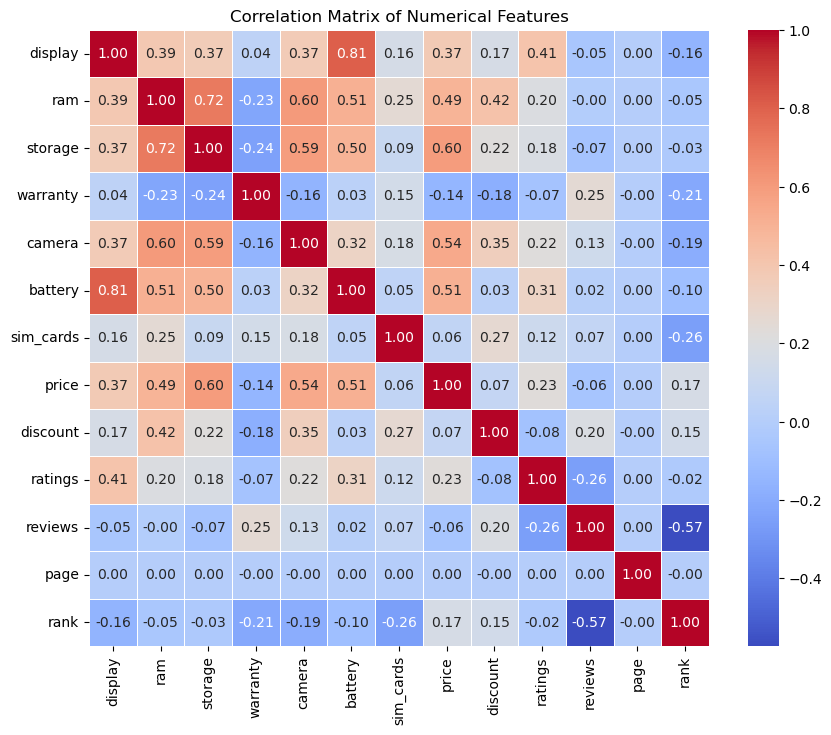

In [61]:
# Calculate the correlation matrix for numerical features
correlation_matrix = final_df.select_dtypes(include=['float64', 'int64']).corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

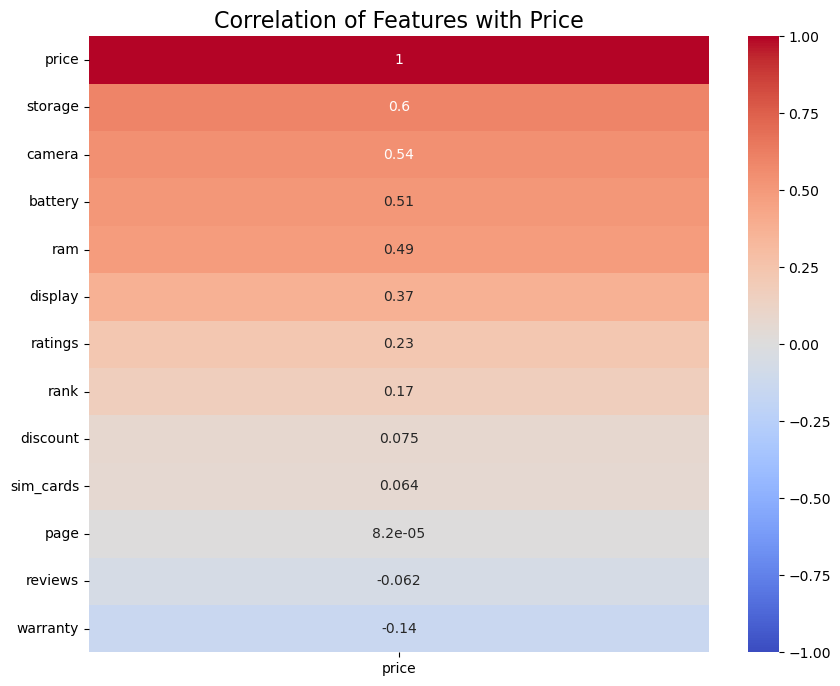

In [62]:
# Plotting a heatmap of correlations
plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation of Features with Price', fontsize=16)
plt.show()

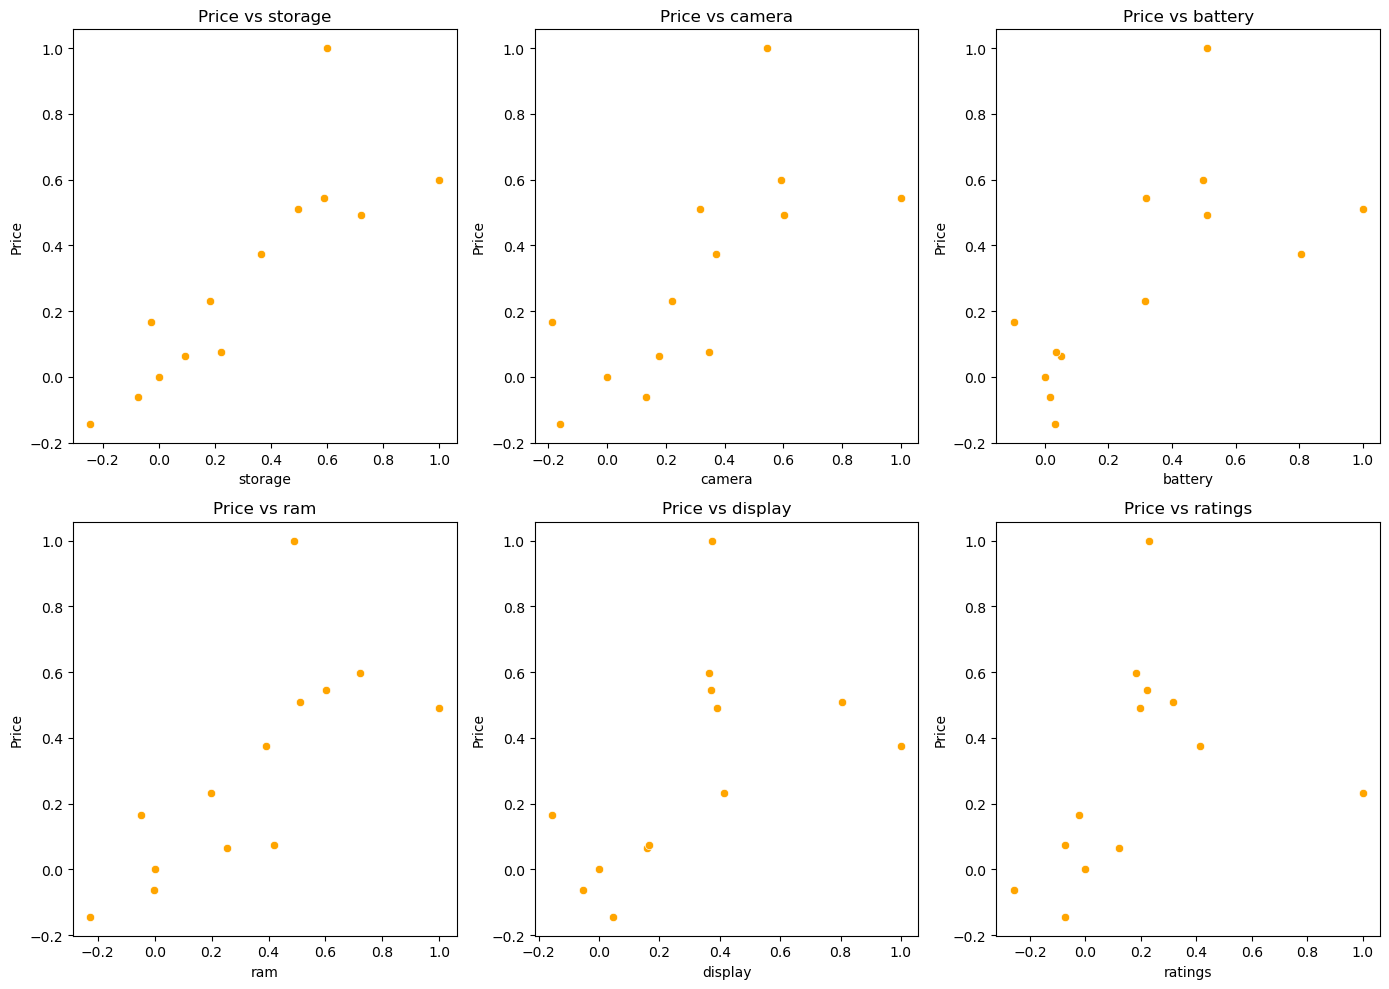

In [63]:
# List of top features that are correlated with 'price'
top_features = ['storage', 'camera', 'battery', 'ram', 'display', 'ratings']

# Create scatter plots for price vs these features
plt.figure(figsize=(14, 10))

for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=correlation_matrix, x=feature, y='price', color='orange')
    plt.title(f'Price vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

/var/folders/m7/31mld3hn46s_y1f05nhxt1_c0000gn/T/ipykernel_20897/1790784352.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='phone_name', y='price', data=final_df, palette='Set2')


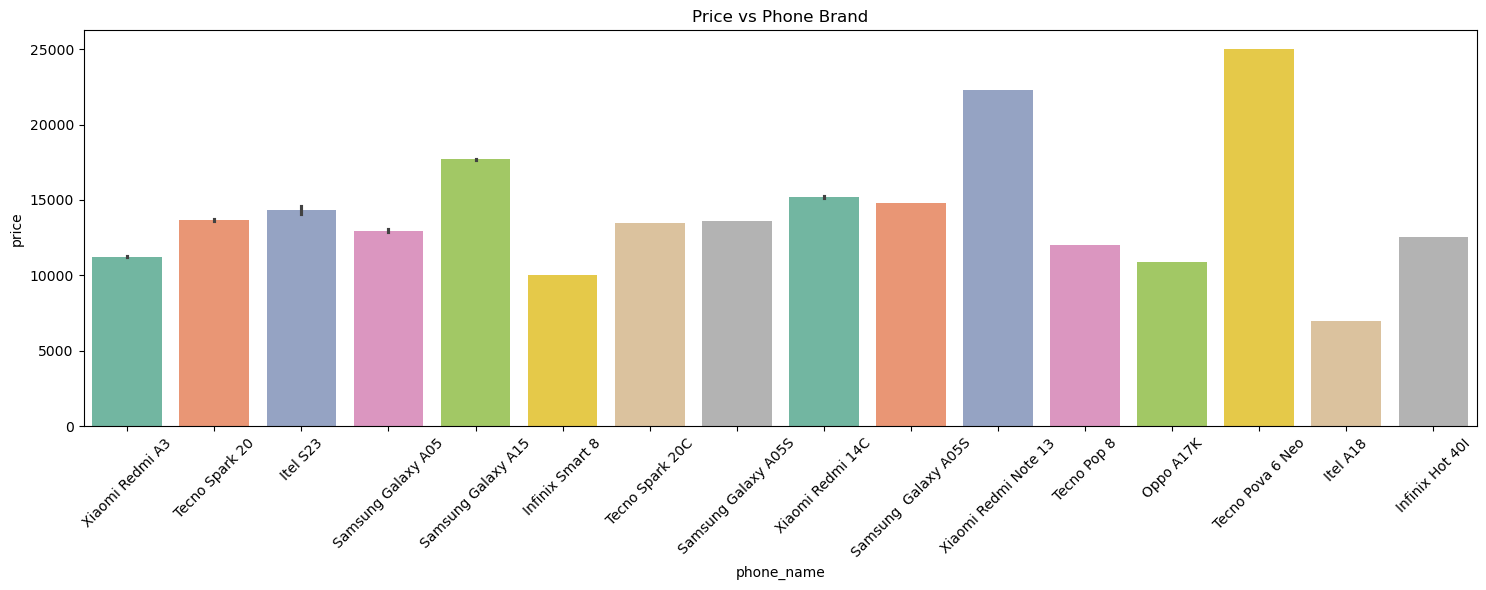

In [64]:
# Set figure size for the plot
plt.figure(figsize=(15, 6))

# Boxplot for 'phone_name' (or any other categorical feature) vs 'price'
sns.barplot(x='phone_name', y='price', data=final_df, palette='Set2')

# Title of the plot
plt.title('Price vs Phone Brand')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Automatically adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()

In [65]:
# Z-score method for outlier detection
z_scores = np.abs(stats.zscore(final_df['price']))

# Find outliers
outliers_zscore = final_df[z_scores > 3]

print(f"Outliers detected using Z-score method: {outliers_zscore}")

Outliers detected using Z-score method: Empty DataFrame
Columns: [phone_name, display, ram, storage, warranty, camera, battery, sim_cards, price, discount, ratings, reviews, page, rank]
Index: []


In [66]:
# IQR Method for detecting outliers
Q1 = final_df['price'].quantile(0.25)
Q3 = final_df['price'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_iqr = final_df[(final_df['price'] < (Q1 - 1.5 * IQR)) | (final_df['price'] > (Q3 + 1.5 * IQR))]

print(f"Outliers detected using IQR method: {outliers_iqr}")

Outliers detected using IQR method:                  phone_name  display  ram  storage  warranty  camera  battery  \
15                 Itel S23     6.78    4      128         0      50     5000   
18     Xiaomi Redmi Note 13     6.67    8      256         0     108     5000   
30         Tecno Pova 6 Neo     6.78    8      256         0      50     7000   
38                 Itel S23     6.78    4      128         0      50     5000   
55                 Itel S23     6.78    4      128         0      50     5000   
...                     ...      ...  ...      ...       ...     ...      ...   
11958              Itel S23     6.78    4      128         0      50     5000   
11975              Itel S23     6.78    4      128         0      50     5000   
11978  Xiaomi Redmi Note 13     6.67    8      256         0     108     5000   
11990      Tecno Pova 6 Neo     6.78    8      256         0      50     7000   
11998              Itel S23     6.78    4      128         0      50     


**Outliers Detected Using the IQR Method**
The IQR (Interquartile Range) method was used to identify outliers in the price column of the dataset. The outliers are phone entries with prices either below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

A total of 1,200 rows (phones) were identified as outliers based on their price values.
These phones generally have prices above 23,000 or below 7,000, which are considered extreme compared to the interquartile range of the price distribution.
This indicates that these particular phones may have unusually high or low prices compared to most of the other entries in the dataset.

We will take note of these outliers, however we will not remove them from the dataset yet.

In [67]:
# Calculate skewness and kurtosis
skewness = final_df['price'].skew()
kurtosis = final_df['price'].kurt()

print(f"Skewness of price: {skewness}")
print(f"Kurtosis of price: {kurtosis}")

Skewness of price: 0.9673614527445935
Kurtosis of price: 0.28612489421567666


**Skewness and Kurtosis of Price**

**Skewness:** The skewness of the price distribution is 0.97, indicating a positive skew. This means the distribution has a longer tail on the higher-price side, with more phones having lower prices and fewer phones with extremely high prices.

**Kurtosis:** The kurtosis is 0.29, which is below 3 (the kurtosis of a normal distribution). This suggests that the price distribution has lighter tails and is flatter compared to a normal distribution, implying fewer extreme price outliers than expected under normal conditions.

In summary, the price distribution is slightly right-skewed with a relatively flat shape.

In [68]:
# Handling the outliers
"""
Outliers can significantly impact the performance of machine learning models and statistical analyses. 
To handle outliers, we can either remove them from the dataset or cap their values at the lower or upper bounds.

In this case, we will use the IQR method to identify and handle outliers in the 'price' column. 
This method removes outliers by keeping only the data points that fall within the range of Q1 - 1.5 * IQR and Q3 + 1.5 * IQR.

Here's the code to handle outliers using the IQR method:
"""

# Defining a function to handle outliers either by removing them from the dataset or cap their values at the lower or upper bounds
def handle_outliers(data, column, method='remove'):
    """
    Handles outliers in the specified column using the IQR method.

    Parameters:
    - data: DataFrame containing the dataset.
    - column: The name of the column to check for outliers.
    - method: The method to handle outliers. Options are 'remove' or 'cap'. Default is 'remove'.
    
    Returns:
    - A DataFrame with outliers handled according to the specified method.
    """
    # Calculate the IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if method == 'remove':
        # Remove rows with outliers
        cleaned_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    elif method == 'cap':
        # Cap the outliers to the lower and upper bounds
        cleaned_data = data.copy()
        cleaned_data[column] = cleaned_data[column].clip(lower=lower_bound, upper=upper_bound)
    else:
        raise ValueError("Method must be either 'remove' or 'cap'")

    return cleaned_data

# Example usage:
# Remove outliers in the 'price' column
cleaned_df_remove = handle_outliers(final_df, 'price', method='remove')

# Cap outliers in the 'price' column
cleaned_df_cap = handle_outliers(final_df, 'price', method='cap')


# Print the sizes of the original and cleaned datasets
print(f"Original dataset size: {final_df.shape}")
print(f"Cleaned dataset (removed outliers) size: {cleaned_df_remove.shape}")
print(f"Cleaned dataset (capped outliers) size: {cleaned_df_cap.shape}")

Original dataset size: (9600, 14)
Cleaned dataset (removed outliers) size: (8400, 14)
Cleaned dataset (capped outliers) size: (9600, 14)


Now that we have dealt with the outliers, let us recheck the skewness of the price feature.

In [69]:
# Calculate skewness and kurtosis
skewness = cleaned_df_cap['price'].skew()
kurtosis = cleaned_df_cap['price'].kurt()

print(f"Skewness of capped dataset: {skewness}")
print(f"Kurtosis of capped dataset: {kurtosis}")

print()

skewness = cleaned_df_remove['price'].skew()
kurtosis = cleaned_df_remove['price'].kurt()

print(f"Skewness of removed dataset: {skewness}")
print(f"Kurtosis of removed dataset: {kurtosis}")

Skewness of capped dataset: 0.7808272803648081
Kurtosis of capped dataset: -0.14032721902357004

Skewness of removed dataset: 0.18628566427001295
Kurtosis of removed dataset: -0.5168637373347309


As we can clearly see the dataset with the outliers removed is better skewed that the one with the capped dataset.

***

## Modeling

Developing a model for predicting price (a continuous variable) is a regression problem, so the best model will depend on several factors, including the structure of our data, the relationships between features, and the complexity we are willing to handle.

Given the columns available in our dataset (e.g., display size, RAM, storage, camera, battery, etc.), different regression models will perform better or worse depending on the nature of the data. Below, we'll outline some common models and methods we are going to use for this regression task, as well as provide an approach to assess the "best" model.

### 1. Linear Regression
Best for: Simple, linearly related features.
Advantages: Easy to interpret, fast to train, and works well for problems where features are linearly related to the target variable.
Disadvantages: May perform poorly if the relationship between the features and target is non-linear.

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

# Define the features (X) and target (y)
# 'price' is the target variable.
X = final_df.drop(columns=['phone_name', 'price'])  # Drop 'phone_name' and 'price' columns
y = final_df['price']  # Price is the target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_test)
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred))
print("Linear Regression R-squared:", r2_score(y_test, y_pred))

Linear Regression MSE: 7143370.121799616
Linear Regression R-squared: 0.6046860944698951


### 2. Random Forest Regressor
Best for: Non-linear relationships and interactions between features.
Advantages: Can model complex relationships, handle missing data, and capture feature importance.
Disadvantages: Requires more computational resources, and predictions can be less interpretable.

In [71]:
# Create and fit the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print("Random Forest MSE:", mean_squared_error(y_test, y_pred))
print("Random Forest R-squared:", r2_score(y_test, y_pred))

Random Forest MSE: 0.8027852083333422
Random Forest R-squared: 0.9999999555738888


### 3. Gradient Boosting Regressor
Best for: Complex relationships with strong predictive power.
Advantages: Often performs very well out-of-the-box and can model complex interactions.
Disadvantages: Can overfit if not tuned properly and might be slower to train.

In [72]:
# Create and fit the model
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = gbr_model.predict(X_test)
print("Gradient Boost Regressor MSE:", mean_squared_error(y_test, y_pred))
print("Gradient Boost Regressor R-squared:", r2_score(y_test, y_pred))

Gradient Boost Regressor MSE: 3358.7435297838933
Gradient Boost Regressor R-squared: 0.9998141272256941


### 4. XGBoost Regressor
Best for: Large, complex datasets where interpretability is less of a concern, but high performance is important.
Advantages: Known for excellent predictive power and efficiency, especially on large datasets.
Disadvantages: Requires careful tuning of hyperparameters.

In [73]:
import xgboost as xgb

# Create and fit the model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
print("XGBoost MSE:", mean_squared_error(y_test, y_pred))
print("XGBoost R-squared:", r2_score(y_test, y_pred))

XGBoost MSE: 2.1764387687047323e-06
XGBoost R-squared: 0.9999999999998795


### 5. Support Vector Regressor (SVR)
Best for: When the relationship between features and the target is highly non-linear, but you're willing to experiment with kernels.
Advantages: Works well with high-dimensional datasets, and can capture non-linear relationships.
Disadvantages: Requires careful scaling and kernel selection. Computationally expensive for large datasets.

In [74]:
from sklearn.svm import SVR

# Create and fit the model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svr_model.predict(X_test)
print("SVR MSE:", mean_squared_error(y_test, y_pred))
print("SVR R-squared:", r2_score(y_test, y_pred))

SVR MSE: 18157248.355607335
SVR R-squared: -0.0048216232322171315


To evaluate and compare the performance of different regression models, you can create a performance matrix that shows various metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared for each model. These metrics will give you a clear idea of how well each model is performing on your dataset.

Let me walk you through the process.

1. Evaluation Metrics:
MSE (Mean Squared Error): Measures the average squared difference between actual and predicted values. Lower is better.
RMSE (Root Mean Squared Error): The square root of MSE. It's in the same units as the target variable and can be more interpretable.
R-squared (R²): Measures the proportion of variance in the target variable explained by the model. Higher is better (closer to 1).
2. Creating a Performance Matrix:
we can use a dictionary to store the results for each model, and then display them as a table.

Here’s the complete code to evaluate multiple models and generate the matrix of results:

In [75]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the features (X) and target (y)
X = final_df.drop(columns=['phone_name', 'price'])
y = final_df['price']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost Regressor': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

# Initialize an empty dictionary to store results
results = {
    'Model': [],
    'MSE': [],
    'RMSE': [],
    'R-squared': []
}

# Loop through each model, fit, predict and evaluate
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results['Model'].append(name)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R-squared'].append(r2)

# Create a DataFrame for better visualization of the results
results_df = pd.DataFrame(results)

# Display the performance matrix
print(results_df)

                         Model           MSE         RMSE  R-squared
0            Linear Regression  7.143370e+06  2672.708387   0.604686
1      Random Forest Regressor  8.027852e-01     0.895983   1.000000
2  Gradient Boosting Regressor  3.358744e+03    57.954668   0.999814
3            XGBoost Regressor  2.176439e-06     0.001475   1.000000
4                          SVR  1.815725e+07  4261.132286  -0.004822


Great! It looks like the Random Forest and XGBoost models are performing extremely well, with R-squared values close to 1. This suggests that these models are highly predictive, and hyperparameter tuning could further optimize their performance.

I'll guide you through the process of hyperparameter tuning and cross-validation to improve your model's performance and ensure it's generalizable.

Steps:
Hyperparameter Tuning: For models like Random Forest and XGBoost, tuning hyperparameters such as the number of trees, tree depth, and learning rate can significantly improve performance.
Cross-validation: Cross-validation helps evaluate model performance by splitting the data into multiple subsets, ensuring the model generalizes well.
We'll use:
GridSearchCV for exhaustive hyperparameter search (you can also use RandomizedSearchCV for more efficiency if the grid is large).
Cross-validation to evaluate model performance.

### 1. Hyperparameter Tuning for Random Forest Regressor:

In [76]:
# Define the model
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid for tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],      # Max depth of each tree
    'min_samples_split': [2, 5],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2],       # Minimum samples required at a leaf node
    'bootstrap': [True, False]        # Whether to use bootstrap sampling
}

# Setup GridSearchCV with cross-validation (5 folds)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, 
                              scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit grid search
grid_search_rf.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search_rf.best_params_)
print("Best cross-validation MSE score: ", -grid_search_rf.best_score_)

# Get the best model from grid search
best_rf_model = grid_search_rf.best_estimator_

# Predict and evaluate the model
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R-squared: {r2_rf:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] EN

### 2. Hyperparameter Tuning for XGBoost:
Here’s how to tune XGBoost using GridSearchCV:

In [77]:
# Define the model
xgb_model = xgb.XGBRegressor(random_state=42)

# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],   # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'max_depth': [3, 6, 10],           # Maximum depth of trees
    'subsample': [0.8, 1.0],           # Fraction of samples used in each boosting round
    'colsample_bytree': [0.8, 1.0],    # Fraction of features used in each boosting round
    'gamma': [0, 0.1, 0.2]             # Regularization term to prevent overfitting
}

# Setup GridSearchCV with cross-validation (5 folds)
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, 
                               scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit grid search
grid_search_xgb.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search_xgb.best_params_)
print("Best cross-validation MSE score: ", -grid_search_xgb.best_score_)

# Get the best model from grid search
best_xgb_model = grid_search_xgb.best_estimator_

# Predict and evaluate the model
y_pred_xgb = best_xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MSE: {mse_xgb:.4f}, RMSE: {rmse_xgb:.4f}, R-squared: {r2_xgb:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_dept

Great! It looks like our models are performing exceptionally well after hyperparameter tuning, with Random Forest and XGBoost achieving near-perfect performance. However, there are a few things to address and consider based on our results:

**Random Forest Performance:**

MSE = 0 and R-squared = 1: These results indicate that your Random Forest model is overfitting, which means it's performing extremely well on the training data but may not generalize well to unseen data.

Possible Issues:

Overfitting: The model might have memorized the data because of too many trees (n_estimators=50) and shallow trees (max_depth=10).
Evaluation: The fact that we're getting MSE = 0 on the test set suggests the model is likely memorizing the test set (or too small a test set) rather than truly generalizing.

Possible Fixes:

Increase test set size: Ensure the test set is sufficiently large (at least 20-30% of the data) to properly evaluate model generalization.
Cross-validation evaluation: we should rely more on the cross-validation results (Best cross-validation MSE score: 1853.79) rather than just the test set performance.
Reduce n_estimators or max_depth further to prevent overfitting.

**XGBoost Performance:**

MSE = 0.0482 and RMSE = 0.2195: This is still a very good performance, and the model is almost perfect in predicting the price, with R-squared = 1.
XGBoost looks like it's also performing well, but just like Random Forest, we should ensure it's not overfitting.

Possible Fixes:

Regularization: You have gamma=0.2, which is a regularization parameter. Try increasing gamma further or adjust other regularization parameters (like lambda and alpha) to prevent overfitting.

Check data split: Ensure the split of the data (training vs test) is done properly, and that the model is not just memorizing the data.
Try different hyperparameters: Sometimes, adjusting hyperparameters further (like reducing n_estimators or adding early stopping) can improve generalization.

### Next Steps:
To validate these results and avoid overfitting, I suggest the following next steps:

**Ensure Proper Data Splitting:**

If you're not already doing so, you should use Stratified K-fold cross-validation or K-fold cross-validation to evaluate model performance more robustly.
Regularization:

For both models, you can apply stronger regularization (like increasing the min_samples_split for Random Forest or gamma for XGBoost).
Also, test with a smaller subset of data for both models to check generalization.
Model Evaluation:

Evaluate models on a completely new, unseen dataset (if available) to check for generalization.
Monitor whether the model is consistently overfitting by comparing performance on the training data vs. the test data.
Performance Metrics:

Learning Curves: Plot learning curves to understand if the model is overfitting or underfitting. If the training MSE is much lower than test MSE, overfitting is happening.
Use cross-validation scores (i.e., from GridSearchCV) for model comparison rather than only using test set scores.

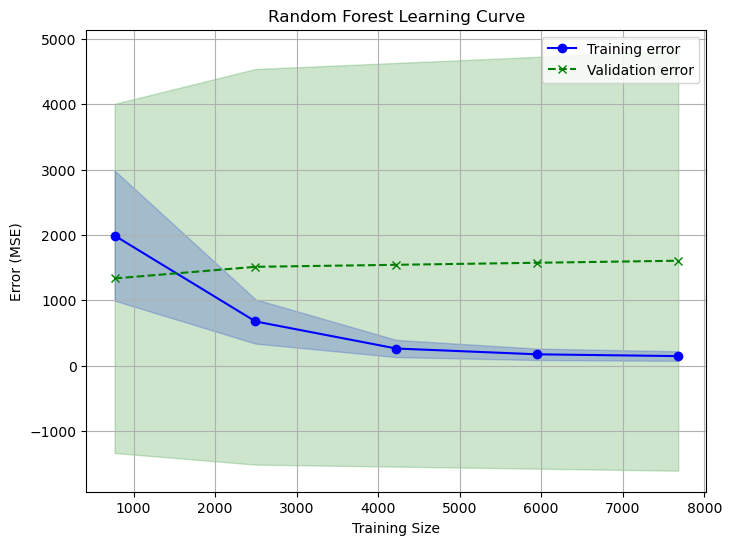

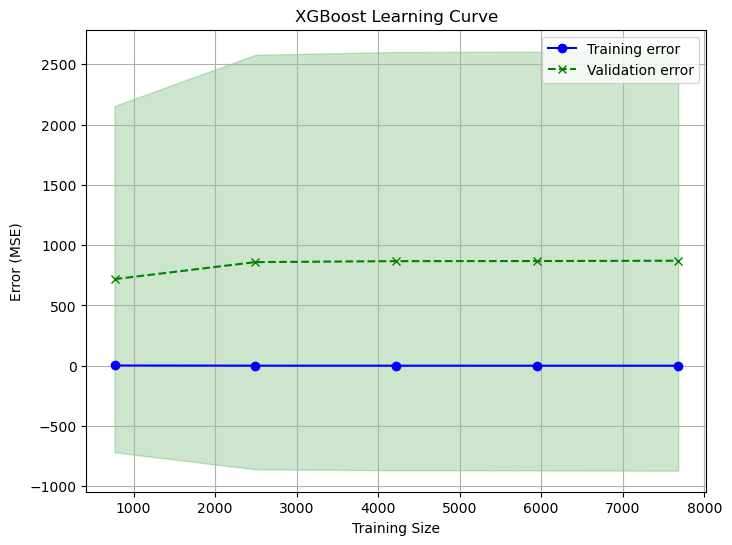

In [78]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Function to plot learning curve
def plot_learning_curve(model, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Calculate mean and std deviation of the scores
    train_mean = -train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = -test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label="Training error", color='blue', linestyle='-', marker='o')
    plt.plot(train_sizes, test_mean, label="Validation error", color='green', linestyle='--', marker='x')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)
    plt.title(title)
    plt.xlabel('Training Size')
    plt.ylabel('Error (MSE)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot learning curves for the Random Forest model
plot_learning_curve(best_rf_model, X, y, title="Random Forest Learning Curve")

# Plot learning curves for the XGBoost model
plot_learning_curve(best_xgb_model, X, y, title="XGBoost Learning Curve")

**Conclusion:**

**Random Forest:** Overfitting might be an issue. Validate using cross-validation and ensure you're using a sufficiently large test set.
**XGBoost:** It performs very well but might need slight regularization tweaks to improve generalization.
Both models are excellent in terms of performance, but make sure you're regularly validating against unseen data or using cross-validation to assess real-world performance.

## Splitting the Dataset
To address the issue with overfitting in our best performing models and to improve performance we are going to split our dataset into training, testing and evaluation sets.
1. Training dataset: Used for model training.
2. Testing dataset: Used for model testing after training, but before final evaluation.
3. Evaluation dataset: Used to assess the final performance of the model after training and testing. Typically, this set is not touched during the training phase.

In [79]:
# Define the features (X) and the target (y)
X = final_df.drop(columns=['price'])  # Drop 'phone_name' and 'price' from features
y = final_df['price']  # Target is 'price'

# Step 1: Split the dataset into training (60%) and temporary (40%) datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Step 2: Split the temporary dataset (40%) into testing (50% of 40%) and evaluation (50% of 40%)
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the shapes of the splits
print(f"Training Set Size: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Set Size: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Evaluation Set Size: X_eval: {X_eval.shape}, y_eval: {y_eval.shape}")

Training Set Size: X_train: (5760, 13), y_train: (5760,)
Testing Set Size: X_test: (1920, 13), y_test: (1920,)
Evaluation Set Size: X_eval: (1920, 13), y_eval: (1920,)


In [80]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define preprocessing for numeric and categorical features
numeric_features = X_train.select_dtypes(include=['float64', 'int32']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown Color')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform the training data, only transform validation and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_eval_processed = preprocessor.transform(X_eval)
X_test_processed = preprocessor.transform(X_test)

# Extract column names after transformation
numeric_col_names = numeric_features
categorical_col_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)

# Combine the feature names
all_feature_names = pd.Index(numeric_col_names).append(pd.Index(categorical_col_names))

# Ensure the columns are correctly aligned with the transformed data
X_train_processed_df = pd.DataFrame(X_train_processed, index=X_train.index, columns=all_feature_names)
X_eval_processed_df = pd.DataFrame(X_eval_processed, index=X_eval.index, columns=all_feature_names[:X_eval_processed.shape[1]]) 
X_test_processed_df = pd.DataFrame(X_test_processed, index=X_test.index, columns=all_feature_names[:X_test_processed.shape[1]])

# Display shapes
print("Shape of X_train_processed_df:", X_train_processed_df.shape)
print("Shape of X_eval_processed_df:", X_eval_processed_df.shape)
print("Shape of X_test_processed_df:", X_test_processed_df.shape)

Shape of X_train_processed_df: (5760, 18)
Shape of X_eval_processed_df: (1920, 18)
Shape of X_test_processed_df: (1920, 18)


In [81]:
# Let us try the linear regression model on the training dataset
from sklearn.linear_model import LinearRegression

# Instantiate the model
lr_model = LinearRegression()

# Fit the model
lr_model.fit(X_train_processed_df, y_train)

# Predict on the validation dataset
y_pred_eval = lr_model.predict(X_eval_processed_df)

# Calculate the metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_lr = mean_absolute_error(y_eval, y_pred_eval)
mse_lr = mean_squared_error(y_eval, y_pred_eval)
r2_lr = r2_score(y_eval, y_pred_eval)

mae_lr, mse_lr, r2_lr

(340.8190104166667, 375987.62649739586, 0.9787394241370339)

In [ ]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost Regressor': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

# Initialize an empty dictionary to store results
results = {
    'Model': [],
    'MSE': [],
    'RMSE': [],
    'R-squared': []
}

# Loop through each model, fit, predict and evaluate
for name, model in models.items():
    # Fit the model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred_processed = model.predict(X_test_processed)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred_processed)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred_processed)
    
    # Store the results
    results['Model'].append(name)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R-squared'].append(r2)

# Create a DataFrame for better visualization of the results
results_df = pd.DataFrame(results)

# Display the performance matrix
print(results_df)

                         Model           MSE         RMSE  R-squared
0            Linear Regression  3.457244e+05   587.983346   0.982469
1      Random Forest Regressor  1.399354e+05   374.079384   0.992904
2  Gradient Boosting Regressor  1.975623e+05   444.479779   0.989982
3            XGBoost Regressor  1.402788e+05   374.538099   0.992887
4                          SVR  1.925954e+07  4388.569095   0.023407


### Observation
Best performing models: Random Forest Regressor, XGBoost Regressor, and Gradient Boosting Regressor. These models are significantly outperforming Linear Regression and SVR in terms of MSE, RMSE, and R².
Worst performing model: SVR, which has the highest MSE and a very low R², indicating that it is not a good fit for this problem.

### Hyperparameter Tuning 

In [ ]:
# Define the parameter grid for Random Forest Regressor
rf_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

# Define the parameter grid for XGBoost Regressor
xgb_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.3],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0]
}

# Define a pipeline for RandomForestRegressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

# Define a pipeline for XGBRegressor
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Grid search for Random Forest Regressor
rf_grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=rf_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)

# Grid search for XGBoost Regressor
xgb_grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
xgb_grid_search.fit(X_train, y_train)

# Print best parameters and best score for Random Forest Regressor
print("Random Forest Regressor Best Parameters: ", rf_grid_search.best_params_)
print("Random Forest Regressor Best Score (MSE): ", rf_grid_search.best_score_)

# Print best parameters and best score for XGBoost Regressor
print("XGBoost Regressor Best Parameters: ", xgb_grid_search.best_params_)
print("XGBoost Regressor Best Score (MSE): ", xgb_grid_search.best_score_)

# Predict using the best Random Forest model
rf_best_model = rf_grid_search.best_estimator_
y_pred_rf = rf_best_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = rf_mse ** 0.5
print(f"Random Forest MSE: {rf_mse}, RMSE: {rf_rmse}")

# Predict using the best XGBoost model
xgb_best_model = xgb_grid_search.best_estimator_
y_pred_xgb = xgb_best_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = xgb_mse ** 0.5
print(f"XGBoost MSE: {xgb_mse}, RMSE: {xgb_rmse}")

Random Forest Regressor Best Parameters:  {'model__bootstrap': True, 'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Random Forest Regressor Best Score (MSE):  -143772.68840457944
XGBoost Regressor Best Parameters:  {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.3, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
XGBoost Regressor Best Score (MSE):  -143734.43102218886
Random Forest MSE: 140044.6730290245, RMSE: 374.2254307620268
XGBoost MSE: 140315.581403459, RMSE: 374.5872146823207


***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Assuming you have your dataset X (features) and y (target)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Function to plot learning curves
def plot_learning_curve(model, X_train, y_train, title="Learning Curve", ylim=None):
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), verbose=0
    )
    
    # Convert negative MAE to positive
    train_scores = -train_scores
    valid_scores = -valid_scores
    
    # Mean and std deviation for train and validation scores
    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label="Training Score", color='b')
    plt.plot(train_sizes, valid_mean, label="Cross-validation Score", color='r')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='b')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='r')
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Mean Absolute Error")
    plt.legend(loc="best")
    if ylim:
        plt.ylim(ylim)
    plt.grid(True)
    plt.show()

# Plot learning curves for Random Forest Regressor
plot_learning_curve(rf_model, X_train, y_train, title="Learning Curve - Random Forest Regressor")

# Plot learning curves for XGBoost Regressor
plot_learning_curve(xgb_model, X_train, y_train, title="Learning Curve - XGBoost Regressor")


ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 745, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/pandas/core/generic.py", line 2150, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Oppo A17K'

--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 745, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/madservices/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/pandas/core/generic.py", line 2150, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Samsung Galaxy A15'
